In [101]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
import csv
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import geopy.distance

In [86]:
# Read the first 200k records from the train dataset that has 55 mil rows
train = pd.read_csv('C:/Users/hchil/Desktop/CSU/Capstone project/train.csv', nrows= 200000)
test = pd.read_csv('C:/Users/hchil/Desktop/CSU/Capstone project/test.csv')
# display the number of rows and columns in train and test datasets 
train.shape, test.shape

((200000, 8), (9914, 7))

In [87]:
# Display top 5 rows
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [88]:
# show statistics 
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.342877,-72.506121,39.922326,-72.518673,39.925579,1.682445
std,9.837855,11.608097,10.048947,10.724226,6.751120,1.306730
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735007,-73.991295,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967068,40.767127,-73.963508,40.768070,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [89]:
# Identify the total missing values for each feature
train.isnull().sum().sort_index()

dropoff_latitude     1
dropoff_longitude    1
fare_amount          0
key                  0
passenger_count      0
pickup_datetime      0
pickup_latitude      0
pickup_longitude     0
dtype: int64

In [90]:
# convert the key as datetime
train['key'] = pd.to_datetime(train['key'])
key = test.key
# convert the key and pickup as datetime
test['key'] = pd.to_datetime(test['key'])
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime']) 
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [91]:
train['Year'] = train['pickup_datetime'].dt.year     # extract the year and store it in a year column    
train['Month'] = train['pickup_datetime'].dt.month     # extract the month and store it in a month column
train['Date'] = train['pickup_datetime'].dt.day       # extract the day and store it in a date column 
train['Day of Week'] = train['pickup_datetime'].dt.dayofweek  # extract the dayofweek and store it 
train['Hour'] = train['pickup_datetime'].dt.hour       # extract the Hour and store it
train.drop('pickup_datetime', axis = 1, inplace = True)  # drop pick datetime and update the dataframe 
train.drop('key', axis = 1, inplace = True)             # drop key and update the dataframe
# repeat the above process on test dataset 
test['Year'] = test['pickup_datetime'].dt.year
test['Month'] = test['pickup_datetime'].dt.month
test['Date'] = test['pickup_datetime'].dt.day
test['Day of Week'] = test['pickup_datetime'].dt.dayofweek
test['Hour'] = test['pickup_datetime'].dt.hour
test.drop('pickup_datetime', axis = 1, inplace = True)
test.drop('key', axis = 1, inplace = True)

In [92]:
# drop the records that has missing values
train.dropna(inplace=True)
# drop the records that meet the below condition
train.drop(train.index[(train.pickup_longitude < -75) | 
           (train.pickup_longitude > -72) | 
           (train.pickup_latitude < 40) | 
           (train.pickup_latitude > 42)],inplace=True)
train.drop(train.index[(train.dropoff_longitude < -75) | 
           (train.dropoff_longitude > -72) | 
           (train.dropoff_latitude < 40) | 
           (train.dropoff_latitude > 42)],inplace=True)

In [93]:

# copy the fare amount to a variable called y and rest of the dataset to X, split the data into train and test
# 25% into the test dataset and 75 into train
X, y = train.drop('fare_amount', axis = 1), train['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

# function to calculate the distnace between the starting and ending points of the trip 
def geo_dist(trip):
    pickup_lat = trip['pickup_latitude']
    pickup_long = trip['pickup_longitude']
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    distance = geopy.distance.geodesic((pickup_lat, pickup_long), 
                                       (dropoff_lat, dropoff_long)).miles
    try:
        return distance
    except ValueError:
        return np.nan
# function to calculate the circle distnace between the starting and ending points of the trip 
def clr_dist(trip):
    pickup_lat = trip['pickup_latitude']
    pickup_long = trip['pickup_longitude']
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    distance = geopy.distance.great_circle((pickup_lat, pickup_long), 
                                       (dropoff_lat, dropoff_long)).miles
    try:
        return distance
    except ValueError:
        return np.nan
# add the distances to the original train dataset 
train['geo'] = train.apply(lambda x: geo_dist(x), axis = 1 )
train['clr'] = train.apply(lambda x: clr_dist(x), axis = 1 )

In [94]:
# calculate the pearson's correlation between the distance and fareamount
data1 = train['geo']
data2 = y
corr, _ = pearsonr(data1, data2)
corr

0.7971350001604671

In [95]:
#The preset parameters will be used to train a booster for 700 rounds and 
#the loss score has to improve at least once every 100 rounds. 
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'min_child_weight': 1, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.7, 
    'max_depth': 10,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

model = xgb.train(xgb_params, dtrain, 700, watchlist, early_stopping_rounds=100, maximize=False, verbose_eval=50)

[16:32:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:14.07797	valid-rmse:13.95956
[50]	train-rmse:4.17595	valid-rmse:4.76213
[100]	train-rmse:3.33889	valid-rmse:4.29070
[150]	train-rmse:2.97208	valid-rmse:4.15828
[200]	train-rmse:2.75271	valid-rmse:4.10570
[250]	train-rmse:2.56924	valid-rmse:4.06889
[300]	train-rmse:2.41249	valid-rmse:4.04634
[350]	train-rmse:2.31167	valid-rmse:4.03833
[400]	train-rmse:2.20542	valid-rmse:4.02612
[450]	train-rmse:2.10472	valid-rmse:4.01968
[500]	train-rmse:2.02634	valid-rmse:4.01640
[550]	train-rmse:1.94366	valid-rmse:4.01175
[600]	train-rmse:1.87846	valid-rmse:4.00998
[650]	train-rmse:1.80947	valid-

In [96]:
# find the accuracy of the model using train and test datasets
#Display the R2-squared and Mean_squared_error
y_train_pred = model.predict(dtrain)
y_pred = model.predict(dvalid)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Train_RMSE {}'.format(train_rmse))
print('Test_RMSE {}'.format(test_rmse))

Train r2 score:  0.9651274344257993
Test r2 score:  0.827458003575317
Train_RMSE 1.7573596052924572
Test_RMSE 4.007157248278734


In [97]:
# Predict the fare amount for the test database 
test_preds = model.predict(dtest)
test_preds

array([ 8.706603 ,  9.4089775,  4.9358406, ..., 52.49838  , 21.453142 ,
        6.176689 ], dtype=float32)

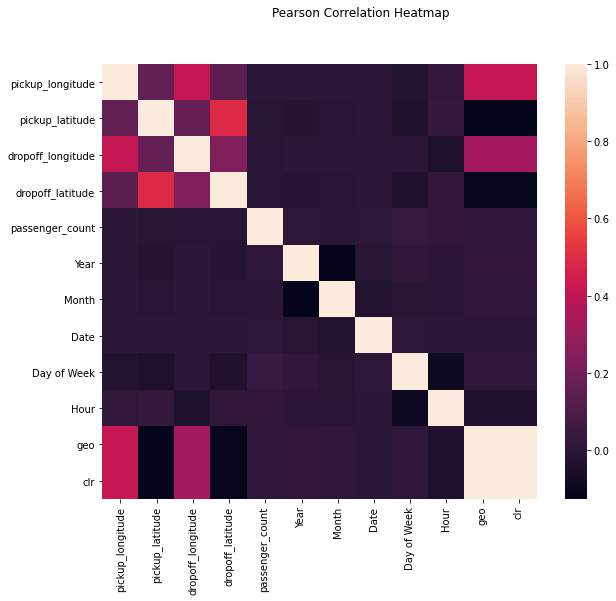

In [98]:
# Plot the Pearson's correlation graph
plt.figure(figsize=(10, 8))
sns.heatmap(train.drop('fare_amount', axis=1).corr(), square=True)
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

C:\Users\hchil\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


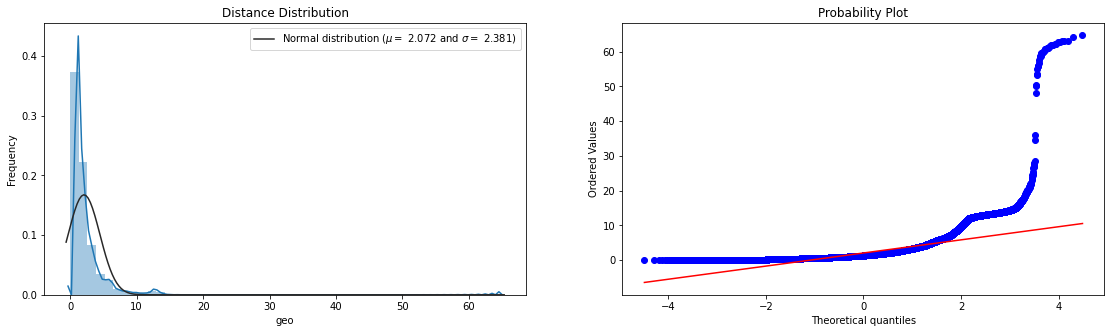

In [99]:
# visualize the distance distribution and probability plot
(mu, sigma) = norm.fit(train['geo'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(train['geo'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Distance Distribution')
ax2 = stats.probplot(train['geo'], plot=plt)
f.show();